# Conditionnal Bernoulli

## question 1

`définition des objet`  
Let $N$ be an integer, and consider the probability vector $p = (p_1, p_2, \dots, p_N)$ where each $p_i$ belongs to the interval $(0,1)$ for  $i = 1, \dots, N$.  
The sample space is given by $\Omega = \{0,1\}^N.$  
We assume that $I$ is an integer satisfying $I \leq \frac{N}{2}$.  
Let $g$ be the probability density function of the random vector  
$$
(X_1, \dots, X_N)
$$
where the $X_i$ are independent Bernoulli random variables $X_i \sim \mathsf{B}(p_i).$  
Finally, let $f$ be the probability density function of  
$$
(X_1, \dots, X_N) \sim \mathsf{CB}(p, I).
$$  

`justification du choix de ce que l'on fait`
We will use the following proposition from the lecture :
> Let $f$, $g$ be probability density functions (PDFs) such that the support of $g$ contains the support of $f$ and
> 
> $$
> f \leq M g \quad \text{with } M \geq 1.
> $$
> 
> ### Accept-Reject Algorithm
> Repeat:  
> 1. Draw $X \sim g$ and $U \sim U[0,1]$.  
> 2. Until $U \leq \frac{f(X)}{M g(X)}$.
> 
> ### Properties:
> - $X \sim f$ 
> - The number of draws until acceptance follows a **Geometric** distribution:  
>   
>   $$
>   \text{Geometric}(1/M).
>   $$  

This propriety can be used because $g$ does not cancel out `j'imagine que c'est comme ça que se dit ne s'annule pas` on $\Omega$.  
We choose the smallest possible $M$ in order to have as little draws as possible 
$$
M = \underset{x \in \Omega}{\sup} \; \frac{f(x)}{g(x)}
$$

<u>Remark</u> : 

Because $N$ is fixed, that's actually a max. 

$$ M = \underset{x \in \Omega}{\max} \; \frac{f(x)}{g(x)}$$

### algorithm du cours aucun changement

In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.stats import geom
from collections import deque

`on mettra sûrement la classe dans un fichier .py pour que ça soit plus lisible`

'Ne penses-tu pas qu'il faudrait iporter intertools comme "import intertools as inter" ? ça serait plus propre non ? '

In [4]:
class RejectionSampling:
    def __init__(self, p, I):  # Default value for m
        self.p = p
        self.I = I
        self.N = len(p)
        self.g = self.pdf_bernoulli(p)  # Bernoulli probability function
        self.f = self.pdf_cb(p, I)  # Conditional probability function
        self.M = self.compute_M(self)  # Compute M
        self._sample = None
        self._acceptances = None
    
    @staticmethod
    def compute_M(self):
        """Computes M based on given m and probability ratios"""
        res = 1
        for seq in self.generate_sequences(self.N, self.I):  # Corrected N and I
            pr = self.f(seq) / self.g(seq)  # Fix missing self.
            if pr > res:
                res = pr
        return res

    def pdf_cb(self, p, I):
        """Computes a conditional probability function"""
        g = self.pdf_bernoulli(p)
        proba = 0
        for x in self.generate_sequences(len(p), I):
            proba += g(x)

        def f(x):
            return g(x) / proba if np.sum(x) == I else 0  # Use np.sum(x)

        return f

    @staticmethod
    def generate_sequences(N, I):
        """Generates all binary sequences of length N with I ones"""
        positions = itertools.combinations(range(N), I)
        sequences = []
        for pos in positions:
            seq = np.zeros(N, dtype=int)  # Start with all zeros
            seq[list(pos)] = 1  # Set the specified positions to 1
            sequences.append(seq)
        return np.array(sequences)

    @staticmethod
    def pdf_bernoulli(p):
        """Creates a Bernoulli probability function"""
        def g(x):
            return np.prod(np.where(x == 1, p, 1 - p))
        return g
    
    def sample(self,L=1):
        samples = []
        acceptances = []
        while len(samples) < L:
            attempt = 0
            while True:
                attempt += 1 
                X = np.array([np.random.binomial(1, p_i) for p_i in self.p])
                U = np.random.uniform(0,1)
                if U<=(self.f(X)/(self.g(X)*(self.M))):
                    samples.append(X)
                    acceptances.append(attempt)
                    break
        self._sample=np.array(samples)
        self._acceptances = np.array(acceptances)
    
    def plot_acceptance_density(self):
        """Plots the empirical density function and the theoretical Geometric(1/M) density."""
        if self._acceptances is None:
            print("No samples generated yet. Run sample() first.")
            return

        unique, counts = np.unique(self._acceptances, return_counts=True)
        empirical_density = counts / np.sum(counts)  # Normalize to get probability values

        # Theoretical geometric distribution with success probability 1/M
        k_values = np.arange(1, max(unique) + 1)  # Range of values for plotting
        theoretical_density = geom.pmf(k_values, 1 / self.M)  # Geometric PMF

        plt.figure(figsize=(8, 5))
        
        # Empirical density as a bar plot
        plt.bar(unique, empirical_density, width=0.8, color='b', alpha=0.7, edgecolor='black', label="Empirical Density")
        
        # Theoretical geometric density as a line plot
        plt.plot(k_values, theoretical_density, 'r-o', markersize=4, label=f"Theoretical Geom(1/{self.M:.2f})", linewidth=1)

        plt.xlabel("Number of Attempts Before Acceptance")
        plt.ylabel("Probability Density")
        plt.title("Empirical vs Theoretical Density of Acceptance Attempts")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

Pour $I$ fixer on va évaluer comment évolue $M$; pour ce fair on va considérer des $p_i$ uniforme sur $(0,1)$. On remarque que pour un $N$ donnée, $M$ va avoir des valeurs extrème essentiellement plus hautes que sa moyenne quartile etc.; pour plusieurs N, on va avoir une croissance des valeurs extrèmes M exponentielle; 

/tmp/ipykernel_203151/3210251214.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(M_values_all, labels=[f'N={N}' for N in N_values])


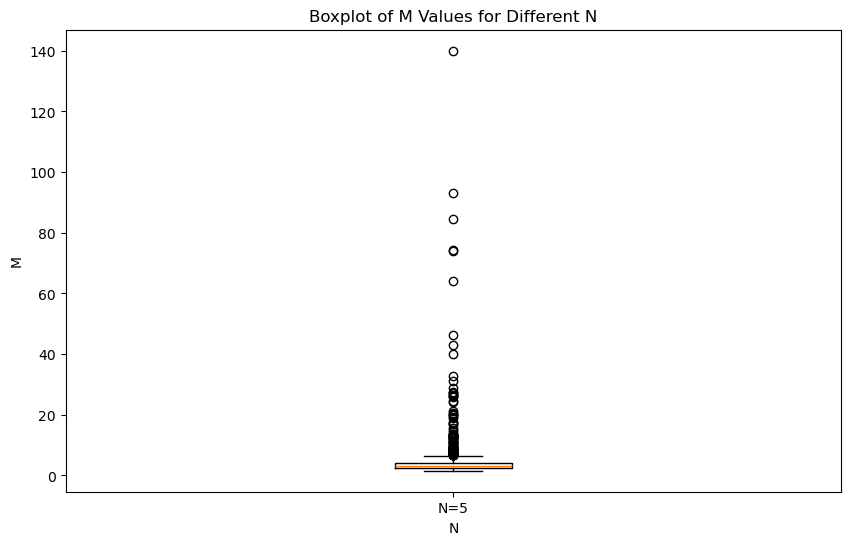

In [5]:
I = 2
num_samples = 1000  # Number of samples to run
N_values = [5]  # Different values for N
M_values_all = []  # To hold M values for each N

# Collect M values across multiple samples for different N
for N in N_values:
    M_values = []
    for _ in range(num_samples):
        p = np.random.uniform(0, 1, N)  # Generate random probabilities p
        sampler = RejectionSampling(p, I)
        M_values.append(sampler.M)
    M_values_all.append(M_values)

# Create a boxplot for each N
plt.figure(figsize=(10, 6))
plt.boxplot(M_values_all, labels=[f'N={N}' for N in N_values])
plt.title('Boxplot of M Values for Different N')
plt.ylabel('M')
plt.xlabel('N')
plt.show()

/tmp/ipykernel_203151/2752977224.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(M_values_all, labels=[f'N={N}' for N in N_values])


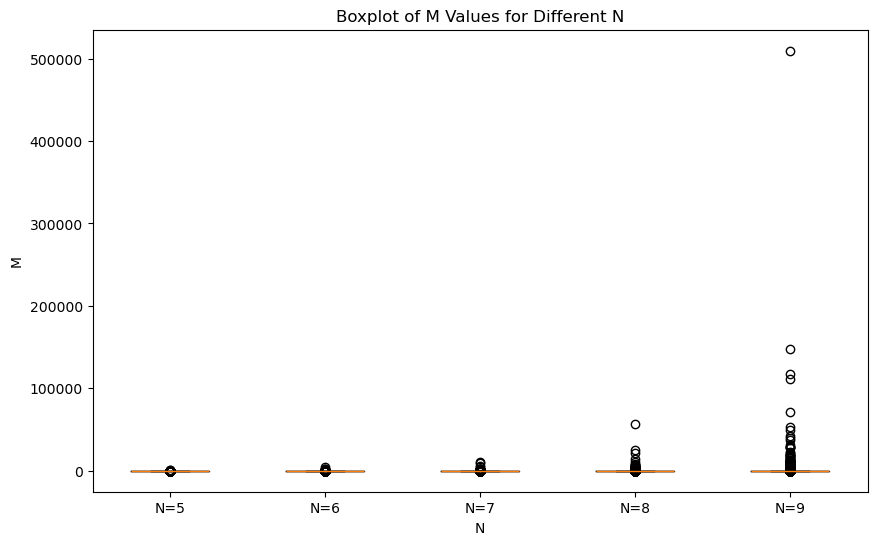

In [6]:
I = 2
num_samples = 10000  # Number of samples to run
N_values = [5,6,7,8,9]  # Different values for N
M_values_all = []  # To hold M values for each N

# Collect M values across multiple samples for different N
for N in N_values:
    M_values = []
    for _ in range(num_samples):
        p = np.random.uniform(0, 1, N)  # Generate random probabilities p
        sampler = RejectionSampling(p, I)
        M_values.append(sampler.M)
    M_values_all.append(M_values)

# Create a boxplot for each N
plt.figure(figsize=(10, 6))
plt.boxplot(M_values_all, labels=[f'N={N}' for N in N_values])
plt.title('Boxplot of M Values for Different N')
plt.ylabel('M')
plt.xlabel('N')
plt.show()

## Question 2

implementation of the algorithm

In [7]:
def sample_conditional_bernoulli(p , I : int):
    """ Take as parametter a list or an array p, which represent the vector of probabilities
     and an int I the bound for x_1+ ...+x_n
    """
    
    #initialization
    p = np.array(p)
    N = len(p)
    q = np.zeros((I + 1, N))
    
    #first condition, if I =0, the conditionnal bernouilli is obviously a vector of 0, for all n in [N] ([N] = {1,...,N})
    if I == 0:
        return np.array([0 for k in range(N)])
    else : 

        # first conditions (first raw is just the product of the probabilities)
        for n in range(N):
            q[0][n] = np.prod(1 - p[n:])

        #the last row of the first column is just p_N
        q[1][N - 1] = p[N - 1]

        # filling of the probability matrix 
        for n in range(N - 2, -1, -1):
            for i in range(1, min(I, N - n) + 1): #+1 because the first row is already made
                q[i][n] = p[n] * q[i - 1][n + 1] + (1 - p[n]) * q[i][ n + 1 ]

        # sampling
        x = np.zeros(N, dtype=int)
        for n in range(N):
            if I > 0:
                prob = q[I, n]
                #condition for get exactly I x_n = 1 and not less
                if n < N - I and prob !=0: # (actually, the second condition is always true for N finite)
                    prob_if_one = p[n] * q[I - 1, n + 1] / prob
                    if np.random.rand() < prob_if_one :#We add this ondition to obtain a random variable
                        x[n] = 1
                        I -=1
                    else :
                        x[n] = 0
                else:
                    x[n] = I
                    I -= 1
        return x

In [8]:
#test

x = sample_conditional_bernoulli([1/2 for i in range(10)], 0)
np.count_nonzero(x),x


(0, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

The construction of the matrix in our ‘sample_conditional_bernoulli’ function is of size $O(N^2)$. Indeed, we know that $I \alpha N$ at most (because $I \le \frac N2$) and so, the double loop is indexed on $\{1,... N-2\}$, and then on $\{1,...,I\}$ ($I$ proportional to $N$) in the "best" case and in the "worst" case, the second loop is repeated $N-1$ times. Thus, the complexity of this loop is $O(N^2)$.

For the second operation of the algorithm, we just get a loop on $\{1, \ldots, n\}$, thus we get a complexity of $O(N)$.

Therefore, we can conclude that the complexity is in order $O(N^2) + O(N) = O(N^2)$.

## Question 3

Let's implement the MCMC (Markov Chain Monte Carlo).

For this, we initialize a vector $X$ which respect the condition $\sum_{i=1}^{N}X_i = I$ (for the moment, X is NOT random). After, if I isn't equal to $0$ or $N$ (because there is no random with that configuration), indeed, $P(X_n = k| \sum_{i=1}^{N}X_i = N) = 0$ if $k \ne 1$ and $=1$ if $k=1$. Symmetrically, we obviously get $P(X_n = k| \sum_{i=1}^{N}X_i = 0) = 0$ if $k \ne 0$ and $=1$ if $k=0$.

Afterward, we just "swap" the different element of our vector $X$ with probability "$\min(1,\frac{w_{i_0}}{w_{i_1}})$" like it is indicated in the paper.

In this algorithm,
$(Y_i)_{i \in [num iterations]}$ is a Markov Chain because $Y_i$ just depend on $Y_{i-1}$, for all $n$. Let's prove it. Let $Y_n = (Y_n^{(1)}, \ldots, Y_n^{(N)})$ a random variable to $\Omega' = \big\{x \in \Omega \mid \sum_{i=1}^Nx_i = I \big\}$ and $i \in [N]$. Let also the set $I_n \in [N]$ which represent the index $(i)$ where $Y_i^{(i)} = 1$, this set <u>just depend on $Y_i$</u>.

Let $i \in [N], k$ an integer :

\begin{align*}
    P(Y_{k+1}^{(i)} = 1)&=P(Y_{k}^{(i)} = 0)[P(Y_{k+1}^{(i)} = 1| Y_{k}^{(i)} = 0)] + P(Y_{k}^{(i)} = 1)[P(Y_{k+1}^{(i)} = 1| Y_{k}^{(i)} = 1)]\\
    &= \frac{N-I}{N}[1-\frac{1}{N-I}\min(1, \sum_{j\in I_n} \frac{1-p_i}{1-p_j})] + \frac{I}{N}[1-P(Y_{k+1}^{(i)} = 0| Y_{k}^{(i)} = 1)] \\
    & = \frac{N-I}{N}[1-\frac{1}{N-I}\min(1, \sum_{j\in I_n} \frac{1-p_i}{1-p_j})] + \frac{I}{N}[1-\frac 1I \min(1, \frac{\sum_{i \in I_n^c}1-p_j}{1-p_i})]
\end{align*}

(Note that we could just left the value $P(Y_{k}^{(i)} = 0)$ to show the property)

With the same reasoning on $P(Y_{k+1}^{(i)}=0)$, we can conclude that ($Y_i$) is a Markov chain, because it just depend on the previous values of $Y_{k-1}, \ldots, Y_1$.

In [90]:
def mcmc_conditional_bernoulli(p, I : int, num_iterations : int):
    p = np.array(p)
    N = len(p)
    # Let's make a X which respect the constraint sum X_i = I
    X = np.zeros(N, dtype=int)
    X[:I] = 1
    np.random.shuffle(X)
    odds = p / (1 - p)
    S0 = list(np.where(X == 0)[0])
    S1 = list(np.nonzero(X)[0])
    
    for nb_iter in range(num_iterations):
        # random selection of 1 and 0
        np.random.shuffle(S0)
        np.random.shuffle(S1)

        # let's take a random element of our index_0/1
        i = S1.pop()
        j = S0.pop()

        # Compute the probability of acceptance
        acceptance_prob = min(1, odds[j] / odds[i])

        # reject or acceptance's swap
        if np.random.rand() < acceptance_prob: # "accept with probability acceptance_prob"
            X[i], X[j] = 0, 1
            S0.append(i)
            S1.append(j) 
        else : #restores origninals values else
            S0.append(j)
            S1.append(i)

    return X

In [92]:
#test
x = mcmc_conditional_bernoulli([1/2 for i in range(1_000)],453, 10_000) 
np.count_nonzero(x)

453

#### Why does this algorithm works ? 

We already proved that $(Y_i)$ is a Markov Chain to $\Omega'$. Let's suppose that $(Y_n) \sim h$, we have $\pi$ the target probability density of $(X_1, \ldots X_N| \sum_{i=1}^{N}X_i = I)$. To apply the Metropolis Hastings algorithm, we need to check out the conditions :

(1) $(Y_i)$ is ergodic (irreducible, recurrent, positive, aperiodic) 

(2) reversibility : for all $x,y \in \Omega', h(x|y) = h(y|x)$, and thus, show that for all $x,y \in \{0,1\}$, we have $\pi(x)h(x|y) = \pi(y)h(y|x)$

Then, when we'll show this, we'll have shown that we have simulated the conditional Bernouilli, because $\pi$ is the joint law of $X_1, \ldots, X_n \sim f, \ldots X_N |\sum_{i=1}^nX_i=I$, then we get the targeted density $f$ which is the $n^{th}$ component of $(Y_n)$. But $Y_i^{(n)}$ with (1) and (2) does converge (when $i \to \infty$) to $f$, thanks to the ergodic theorem, it will show that this algorithm is valide.

<u> Proof :</u>

- (1) Because $N$ is finite, $\Omega'$ is also finite and $(Y_i)$ is a Markov chain irreducible (clearly, because, all the state of $\Omega'$ are available and communicate) to $\Omega'$ finite. Thus we can say that ($Y_i$) is also recurrent and positive. Furthermore, for all state $x \in \Omega'$, we can find a period stay to this stat with probability not null, and thus our chain is aperiodic. Thus $(Y_i)$ is an ergodic Markov Chain and so does converge to it's invariant probability $\pi$.

- (2) $h$ is the probability density of $(Y_i)$, because the problem is symmetrical, that is clear that for all $x,y \in \Omega'$, we get 

$$h(x|y) = P(Y_{k+1} = x|Y_k = y) = P(Y_{k+1} = y|Y_k = x) = h(y|x)$$

Thus, because $\pi(x)$ is the density of $X_1, \ldots, X_n | \sum_{i=1}^nX_i=I$, we get $\pi(x)\alpha \frac{dP_{X_1, \ldots, X_n}(x,I)}{d \mu \otimes \mu} \alpha \Pi_{i=1}^N p_i^{X_i}(1-p_i)^{1-X_i}$ ($I$ is a simplification but juste conditioned with $\sum_{i=1}^nX_i=I$, $\mu$ the counting measuring). So, we can now conclude because let $x,y \in \Omega'$, we get 

\begin{align*}
    \pi(x)h(x|y) &= \pi(y)h(y|x)\\
    \iff \pi(x)&=\pi(y)\\
    \iff \frac{p_i^{X_i}(1-p_i)^{1-X_i}}{p_i^{X_i}(1-p_i)^{1-X_i}} &= 1
\end{align*}

What is True, so, by the explanation after (1) and (2) in the previous markdown, we showed why this algorithms works.

#### How to asses the mixing of our chain $(Y_i)$ ?









To asses the mixing of our Chain, and so, know if $(Y_i)$ visit well all the possible states, we can evaluate the meeting time of two chain $(Y_i), (\tilde Y_i)$ and thus, determine the level of mixing of our algorithm. $ (\tilde Y_i)$ start in an arbitrary state, different from $(Y_i)$. And then, compute the minimum time of meeting of those two chain. The main purpose of the paper is about a non identical distribution of $(p_1, \ldots p_N)$ thus we'll compute the meeting time in this situation.

To explain our approach, this algorithm is based on the statement : if two copy of Markov chain $ (Y_i)_{1 \le i \le M}$  and $ (\tilde Y_i)_{1 \le i \le M }$ evolve together but from different states, and end up meeting, we can deduce that one of them is near of the other, and thus, there are near there limit law $\pi$. We already proved why our Markov chain is converging to the conditional Bernoulli law, according to the Metropolis Hastings algorithm, so we can use the convergence of our two Markov chain.

Moreover, we can arg a little bit more mathematically, with the state that 

$$\lVert x^{(t)} -CB(p,I) \rVert_{TV} \le P(x^{(t)} \ne \tilde x^{(t)})$$

in other word 

$$\lVert P(x^{(t)})-\pi \rVert_{TV}  \le \mathbb{E}(\mathbb{1}_{\tau > t}) = P(\tau >t) $$


With the $\tau$ defined in the code just bellow.

In [26]:
def swap_mcmc(x, y, p):
    """
    return the common swap of x,y like the function mcmc_conditional_bernoulli for just one iteration.
    That function DOES NOT WORKS if I=N or I=0, but in this case, there is no need to check the mixing. 
    """
    x, y = x.copy(), y.copy()
    odds = p / (1 - p)
    # Making the different set presented in 2.2
    S0_x = list(np.where(x == 0)[0])
    S1_x = list(np.nonzero(x)[0])
    S0_y = list(np.where(y == 0)[0])
    S1_y = list(np.nonzero(y)[0])
    if len(S0_x) == 0 or len(S1_x) == 0 or len(S0_y) == 0 or len(S1_y) == 0:
        raise ValueError("Invalid swap set: one of the chains has I = 0 or I = N.")

    # Maximal coupling for i0
    common_S0 = list(set(S0_x) & set(S0_y)) 
    alpha0 = min(len(common_S0) / len(S0_x), len(common_S0) / len(S0_y))
    # Choose a random i, in common S_0, more we have commmon values, more we would choose them
    if len(common_S0) > 0 and np.random.rand() < alpha0:
        i0 = np.random.choice(common_S0) 
        j0 = i0
    else:
        diff_x = list(set(S0_x) - set(S0_y))
        diff_y = list(set(S0_y) - set(S0_x))
        i0 = np.random.choice(diff_x)
        j0 = np.random.choice(diff_y)

    # Maximal coupling for i1, same as the previous loop
    common_S1 = list(set(S1_x) & set(S1_y))
    alpha1 = min(len(common_S1) / len(S1_x), len(common_S1) / len(S1_y))
    if len(common_S1) > 0 and np.random.rand() < alpha1:
        i1 = np.random.choice(common_S1)
        j1 = i1
    else:
        diff_x = list(set(S1_x) - set(S1_y))
        diff_y = list(set(S1_y) - set(S1_x))
        i1 = np.random.choice(diff_x)
        j1 = np.random.choice(diff_y)

    u = np.random.rand()
    if u < min(1, odds[i0] / odds[i1]):
        x[i0], x[i1] = 1, 0
    if u < min(1, odds[j0] / odds[j1]):
        y[j0], y[j1] = 1, 0

    return x, y

def initial_state_hammer(I : int, N : int):
    """ 
    generate two random vectors x,y which follow x_1+ ... + x_N = I, y_1+ ... + y_N =I AND d(x,y) = somme 1(x_i != y_i) = 2
    """
    x = np.array([1]*I + [0]*(N-I))
    np.random.shuffle(x)

    idx_1 = np.where(x == 1)[0]
    idx_0 = np.where(x == 0)[0]
    i1 = np.random.choice(idx_1)
    i0 = np.random.choice(idx_0)

    y = x.copy()
    y[i1], y[i0] = 0, 1

    return x,y
    
def meeting_time( epsilon : float, M : int, I : int, p, L =1):
    """
    Let L be the lag, epsilon the error, M the number of iteration, I like before
    """
    p = np.array(p)
    N = len(p)
    meeting_time = []
    
    for _ in range(M) :
        x,y = initial_state_hammer(I,N)
        tau = 0
        while True :
            x,y = swap_mcmc(x,y,p)
            tau += 1
            if np.array_equal(x, y): 
                meeting_time.append(tau)
                break
    t = 0
    #print(np.mean(meeting_time), np.max(meeting_time), np.min(meeting_time))
    while True :
        total_variation_t = np.mean([max(0, np.ceil((tau_i - L - t) / L)) for tau_i in meeting_time])
        if total_variation_t <= epsilon :
            return t
        t +=1

def probability_generator(N : int): 
    p = np.array([np.random.uniform(0,1) for _ in range(N)])
    return p



In [27]:
#test : samples = [X.copy()]  # Collect samples 

p = probability_generator(100)

meeting_time(epsilon=0.01,M=500,I=45,p=p) 



473

Thus, we checked that the mixing time is approximately in order $N \log(N)$. Let's see it with a plot.

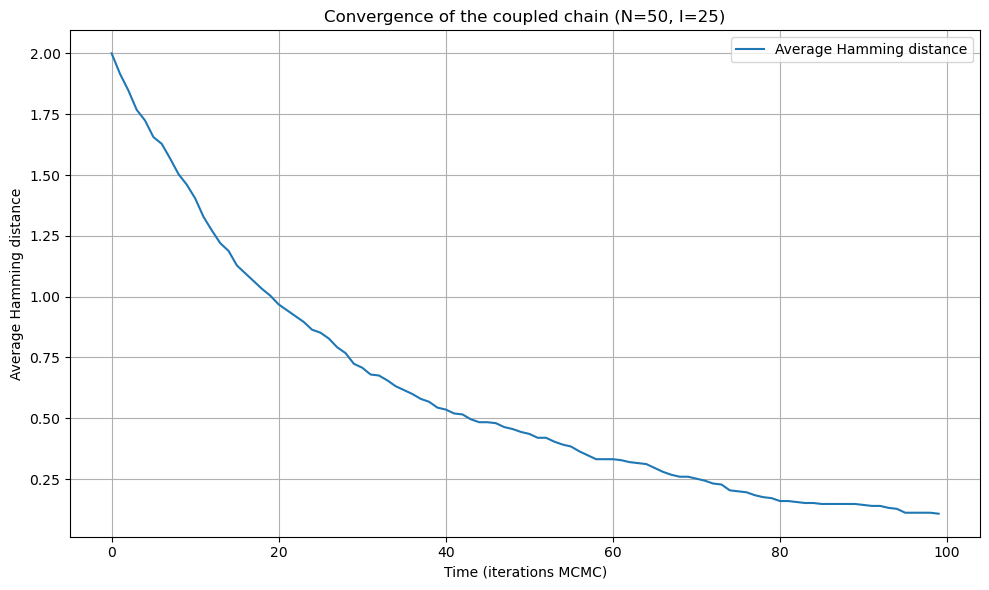

In [35]:

def hamming_distance(x, y):
    return np.sum(x != y)

def simulate_convergence(I, N, p, M=500, max_steps=100): # max step to avoid infinite loop
    distances = np.zeros((M, max_steps))

    for m in range(M):
        x, y = initial_state_hammer(I, N)
        for t in range(max_steps):
            distances[m, t] = hamming_distance(x, y)
            if np.array_equal(x, y):
                # stay at 0 after meeting
                distances[m, t:] = 0
                break
            x, y = swap_mcmc(x, y, p)

    # Mean on the M-trajectory
    mean_dist = distances.mean(axis=0)
    return mean_dist

# Parameters
N = 50
I = 25
p = probability_generator(N)
M = 500       
max_steps = 100

# Simulation
mean_hamming = simulate_convergence(I, N, p, M=500, max_steps=max_steps)


plt.figure(figsize=(10, 6))
plt.plot(mean_hamming, label='Average Hamming distance')
plt.xlabel("Time (iterations MCMC)")
plt.ylabel("Average Hamming distance")
plt.title(f"Convergence of the coupled chain (N={N}, I={I})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Let's see a boxplot to understand the distribution and the reliability of that algorithm 

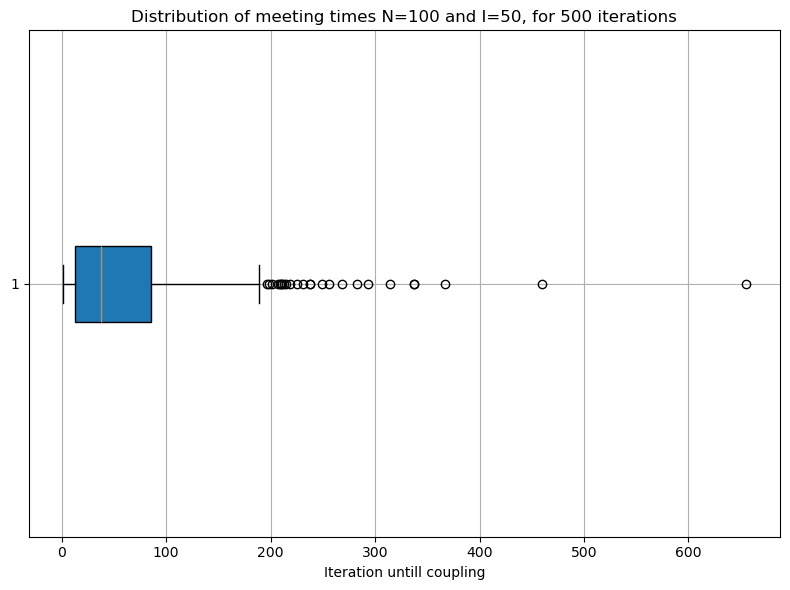

In [37]:
def get_meeting_times(I, N, p, M=500, max_steps=1000): # max step to avoid infinite loop
    meeting_times = []
    for _ in range(M):
        x, y = initial_state_hammer(I, N)
        for t in range(max_steps):
            if np.array_equal(x, y):
                meeting_times.append(t)
                break
            x, y = swap_mcmc(x, y, p)
        else:
            meeting_times.append(max_steps)  
    return meeting_times

# Boxplot
I = 50
N = 100
M = 500
p = probability_generator(N)

meeting_times = get_meeting_times(I=I, N=N, p=p,)
plt.figure(figsize=(8, 6))
plt.boxplot(meeting_times, vert=False, patch_artist=True)
plt.title(f"Distribution of meeting times N={N} and I={I}, for {M} iterations")
plt.xlabel("Iteration untill coupling")
plt.grid(True)
plt.tight_layout()
plt.show()


Well, we notice that in average, for $N=100$, we get a meeting time lower than $100\times \log(100)$ this is an efficient mixing !  